<img src="figure/clairvoyance_logo.png">

# Clairvoyance: Time-series prediction

## ML-AIM (http://vanderschaar-lab.com/)

This notebook describes the user-guide of a time-series predictions application using Clairvoyance framework. Time-series prediction is defined as following: utilize both static and temporal features to predict certain labels in the future. For instance, using the temporal data (vitals, lab tests) and static data (demographic information), we predict 'whether the patient will die at the end of hospital stay' or 'whether the patient will get ventilator after 4 hours'. 
- One-shot prediction: Predict the patient state at the end of the time-series at certain time point.
  - Example: Predict patient mortality (at the end of the hospital stays) after 24 hours from the admission.
- Rolling window (online) prediction:
  - Example: Predict ventilator after 24 hours from the current time point.
 
<img src="figure/time-series-prediction-definition.png">

To run this tutorial, you need:
### Temporal and static datasets for training and testing

If users come with their own temporal and static datasets for training and testing, the users should save those files as 'data_name_temporal_train_data_eav.csv.gz', 'data_name_static_train_data.csv.gz', 'data_name_temporal_test_data_eav.csv.gz', 'data_name_static_test_data.csv.gz' in '../datasets/data/data_name/' directory.


### Prerequisite
Clone https://github.com/jsyoon0823/time-series-automl.git to the current directory.

## Time-series prediction pipeline summary

<img src="figure/time-series-prediction-block-diagram.png">

### Step 1: Load dataset
  - Extract csv files from the original raw datasets in ../datasets/data/data_name/ directory.  
  
### Step 2: Preprocess dataset
  - Preprocessing the raw data using various filters such as (1) replacing negative values to NaN, (2) do one-hot encidng for certain features, (3) do normalization.  
  
### Step 3: Define problem
  - Set the time-series prediction problem that we want to solve. Set the problem (whether it is one-shot or online prediction), set the label, set the maximum sequence length, and set the treatment features. We also define the metric for evaluation and the task itself (whether classification or regression).

### Step 4: Impute dataset
  - Impute missing values in the preprocessed static and temporal datasets and return complete datasets.
  
### Step 5: Feature selection
  - Select the relevant static and temporal features to the labels. You can skip the feature selection (set feature selection method = None).
  
### Step 6: Time-series model fit and predict
  - After finishing the data preparation, we define the predictive models and train the model using the training dataset. After training, we use the trained model to predict the labels of the testing dataset.
  
### Step 7: Estimate uncertainty
  - Estimate uncertainty of the predictor models and returns the uncertainty of the predictions.

### Step 8: Interpret predictions
  - Interpret the trained predictor model and return the instance-wise feature and temporal importance.

### Step 9: Visualize results
  - Visualize the various results such as performance, predictions, uncertainties, and interpretations.

## Step 0: Import necessary packages

Import necessary packages for the entire tutorials.

In [35]:
# Necessary packages
# from __future__ import absolute_importb
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../')

In [36]:
from utils import PipelineComposer

## Step 1: Load dataset

Extract temporal and static datasets from 'data_name_temporal_train_data_eav.csv.gz', 'data_name_static_train_data.csv.gz', 'data_name_temporal_test_data_eav.csv.gz', 'data_name_static_test_data.csv.gz' in '../datasets/data/data_name/' directory.

- CSVLoader: Load csv files from the original raw datasets in ../datasets/data/data_name/ directory.
- file_names: mimic in this tutorial.

In [37]:
from datasets import CSVLoader

# Define data name
data_name = "practice"
# Define data dictionary
data_directory = "../datasets/data/practice/"

# Load train and test datasets
data_loader_training = CSVLoader(
    static_file=data_directory + "train_static.csv", temporal_file=data_directory + "train_temporal.csv"
)

data_loader_testing = CSVLoader(
    static_file=data_directory + "test_static.csv", temporal_file=data_directory + "test_temporal.csv"
)

dataset_training = data_loader_training.load()
dataset_testing = data_loader_testing.load()

print("Finish data loading.")

Finish data loading.


In [38]:
dataset_training.temporal_data.head()

variable,id,time,above_15k_sales,automotive_sales,baby_care_sales,beauty_sales,beverages_sales,books_sales,bread/bakery_sales,celebration_sales,...,meats_sales,personal_care_sales,pet_supplies_sales,players_and_electronics_sales,poultry_sales,prepared_foods_sales,produce_sales,school_and_office_supplies_sales,seafood_sales,total_sales
0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.0,0.00000,0.000,0.0,0.0,0.000000,0.000000
1,2,1,0.0,8.0,0.0,3.0,1481.0,0.0,523.882,0.0,...,655.626,333.0,0.0,0.0,342.50598,127.357,0.0,0.0,31.373001,10266.718981
2,2,2,0.0,5.0,0.0,2.0,1016.0,0.0,321.693,0.0,...,597.745,236.0,0.0,0.0,317.65200,92.043,0.0,0.0,34.343000,7612.540000
3,2,3,0.0,3.0,0.0,3.0,1146.0,0.0,299.012,0.0,...,689.216,188.0,0.0,0.0,305.01900,78.303,0.0,0.0,49.833000,7526.377000
4,2,4,0.0,5.0,0.0,9.0,1581.0,0.0,385.333,0.0,...,578.157,245.0,0.0,0.0,383.70000,82.112,0.0,0.0,43.962000,9539.566000


## Step 2: Preprocess dataset

Preprocess the raw data using multiple filters. In this tutorial, we replace all the negative values to NaN (using NegativeFilter), do one-hot encoding on 'admission_type' feature (using OneHotEncoder), and do MinMax Normalization (using Normalization). Preprocessing is done for both training and testing datasets. 
  - NegativeFilter: Replace negative values to NaN
  - OneHotEncoder: One hot encoding certain features
    - one_hot_encoding: input features that need to be one-hot encoded
  - Normalization (3 options): MinMax, Standard, None

In [39]:
from preprocessing import OneHotEncoder

# (2) one-hot encode categorical features
one_hot_encoding = ["city", "state", "type", "family"]
onehot_encoder = OneHotEncoder(one_hot_encoding_features=one_hot_encoding)

# Data preprocessing
filter_pipeline = PipelineComposer(onehot_encoder)

dataset_training = filter_pipeline.fit_transform(dataset_training)
dataset_testing = filter_pipeline.transform(dataset_testing)

print("Finish preprocessing.")

Finish preprocessing.


In [40]:
dataset_training.temporal_data.head(1000)
# dataset_testing.temporal_data.head(500)

variable,id,time,above_15k_sales,automotive_sales,baby_care_sales,beauty_sales,beverages_sales,books_sales,bread/bakery_sales,celebration_sales,...,meats_sales,personal_care_sales,pet_supplies_sales,players_and_electronics_sales,poultry_sales,prepared_foods_sales,produce_sales,school_and_office_supplies_sales,seafood_sales,total_sales
0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.000,0.0,0.0,0.0,0.00000,0.00000,0.0000,0.0,0.000000,0.000000
1,2,1,0.0,8.0,0.0,3.0,1481.0,0.0,523.882,0.0,...,655.626,333.0,0.0,0.0,342.50598,127.35700,0.0000,0.0,31.373001,10266.718981
2,2,2,0.0,5.0,0.0,2.0,1016.0,0.0,321.693,0.0,...,597.745,236.0,0.0,0.0,317.65200,92.04300,0.0000,0.0,34.343000,7612.540000
3,2,3,0.0,3.0,0.0,3.0,1146.0,0.0,299.012,0.0,...,689.216,188.0,0.0,0.0,305.01900,78.30300,0.0000,0.0,49.833000,7526.377000
4,2,4,0.0,5.0,0.0,9.0,1581.0,0.0,385.333,0.0,...,578.157,245.0,0.0,0.0,383.70000,82.11200,0.0000,0.0,43.962000,9539.566000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,997,0.0,12.0,0.0,3.0,3085.0,0.0,664.599,16.0,...,628.197,244.0,8.0,14.0,592.17700,127.03900,2117.1490,0.0,55.082000,14126.552000
996,2,998,1.0,6.0,0.0,4.0,4228.0,0.0,808.000,10.0,...,517.559,332.0,8.0,9.0,573.11700,186.64300,3141.8990,0.0,50.721000,18260.331000
997,2,999,1.0,7.0,0.0,10.0,5373.0,0.0,883.271,9.0,...,419.281,406.0,4.0,8.0,605.93800,204.58301,3469.6260,0.0,45.368000,20693.301010
998,2,1000,0.0,5.0,0.0,2.0,2986.0,0.0,636.000,7.0,...,364.668,219.0,11.0,7.0,439.32700,79.14700,2207.6200,0.0,23.197000,12586.234000


## Step 3: Define problem   

Set the time-series prediction problem that we want to solve. Set the problem (whether it is one-shot or online prediction), set the label, set the maximum sequence length, and set the treatment features. We also define the metric for evaluation and the task itself (whether classification or regression). In this tutorial, we predict whether the patients will get ventilator after 4 hours (online setting).
  - problem: 'one-shot'(one time prediction) or 'online'(rolling window prediction)
    - 'one-shot': one time prediction at the end of the time-series 
    - 'online': preditcion at every time stamps of the time-series
  - max_seq_len: maximum sequence length of time-series sequence
  - label_name: the column name for the label(s)
  - treatment: the column name for treatments
  - window: x-hour ahead prediction.
  
  - other parameters:
    - metric_name: auc, apr, mse, mae
    - task: classification or regression

In [41]:
from preprocessing import ProblemMaker

# Define parameters
problem = 'online'
max_seq_len = 500
label_name = 'above_15k_sales'
treatment = None
window = 0
# Define problem 
problem_maker = ProblemMaker(problem=problem, label=[label_name],
                             max_seq_len=max_seq_len, treatment=treatment, window = window)

dataset_training = problem_maker.fit_transform(dataset_training)
dataset_testing = problem_maker.fit_transform(dataset_testing)

# Set other parameters
metric_name = 'auc'
task = 'classification'

metric_sets = [metric_name]
metric_parameters =  {'problem': problem, 'label_name': [label_name]}

print('Finish defining problem.')

100%|██████████| 6/6 [00:00<00:00, 414.71it/s]

Finish defining problem.


## Step 4: Impute dataset

Impute missing values in the preprocessed static and temporal datasets and return complete datasets.
  - Static imputation (6 options): mean, median, mice, missforest, knn, gain
  - Temporal imputation (8 options): mean, median, linear, quadratic, cubic, spline, mrnn, tgain

In [42]:
# from imputation import Imputation

# # Set imputation models
# static_imputation_model = 'median'
# temporal_imputation_model = 'median'

# # Impute the missing data
# static_imputation = Imputation(imputation_model_name = static_imputation_model, data_type = 'static')
# temporal_imputation = Imputation(imputation_model_name = temporal_imputation_model, data_type = 'temporal')

# imputation_pipeline = PipelineComposer(static_imputation, temporal_imputation)

# dataset_training = imputation_pipeline.fit_transform(dataset_training)
# dataset_testing = imputation_pipeline.transform(dataset_testing)

# print('Finish imputation.')

## Step 5: Feature selection

Select the relevant static and temporal features to the labels. If you do not want, we can skip the feature selection (set feature selection method = None).
  - feature selection method: 
      - feature_selection_model: greedy-addition, greedy-deletion, recursive-addition, recursive-deletion, None
      - feature_number: selected featuer number

In [43]:
# from feature_selection import FeatureSelection

# # Set feature selection parameters
# static_feature_selection_model = None
# temporal_feature_selection_model = None
# static_feature_selection_number = None
# temporal_feature_selection_number = None

# # Select relevant features
# static_feature_selection = \
# FeatureSelection(feature_selection_model_name = static_feature_selection_model,
#                  feature_type = 'static', feature_number = static_feature_selection_number,
#                  task = task, metric_name = metric_name,
#                  metric_parameters = metric_parameters)

# temporal_feature_selection = \
# FeatureSelection(feature_selection_model_name = temporal_feature_selection_model,
#                  feature_type = 'temporal', feature_number = temporal_feature_selection_number,
#                  task = task, metric_name = metric_name,
#                  metric_parameters = metric_parameters)

# feature_selection_pipeline = PipelineComposer(static_feature_selection, temporal_feature_selection)

# dataset_training = feature_selection_pipeline.fit_transform(dataset_training)
# dataset_testing = feature_selection_pipeline.transform(dataset_testing)

# print('Finish feature selection.')

## Step 6: Time-series model fit and predict

After finishing the data preparation, we define the predictive models (6 options, RNN, GRU, LSTM, Attention, Temporal CNN, and Transformer), and train the model using the training dataset. We set validation set as the 20% of the training set for early stopping and best model saving. After training, we use the trained model to predict the labels of the testing dataset.

- predictor_parameters:
  - model_name: rnn, gru, lstm, attention, tcn, transformer
  - model_parameters: network parameters such as numer of layers
    - h_dim: hidden dimensions
    - n_layer: layer number
    - n_head: head number (only for transformer model)
    - batch_size: number of samples in mini-batch
    - epochs: number of epochs
    - learning_rate: learning rate
  - static_mode: how to utilize static features (concatenate or None)
  - time_mode: how to utilize time information (concatenate or None)

In [44]:
from prediction import prediction

# Set predictive model
model_name = 'transformer'

# Set model parameters
model_parameters = {'h_dim': 512,
                    'n_layer': 4,
                    'n_head': 4,
                    'batch_size': 128,
                    'epoch': 20,
                    'model_type': model_name,
                    'learning_rate': 0.001,
                    'static_mode': 'Concatenate',
                    'time_mode': 'Concatenate',
                    'verbose': True}

# Set up validation for early stopping and best model saving
dataset_training.train_val_test_split(prob_val=0.2, prob_test = 0.0)

# Train the predictive model
pred_class = prediction(model_name, model_parameters, task)
pred_class.fit(dataset_training)
# Return the predictions on the testing set
test_y_hat = pred_class.predict(dataset_testing)

print('Finish predictor model training and testing.')

Validation Results - Epoch[1] Avg loss: 2087.03
Validation Results - Epoch[2] Avg loss: 4339.07
Validation Results - Epoch[3] Avg loss: 1695.40
Validation Results - Epoch[4] Avg loss: 1957.31


## Step 7: Estimate uncertainty

Estimate uncertainty of the predictor models and returns the uncertainty of the predictions (test_ci_hat).

- uncertainty_parameters:
  - uncertainty estimation model name (ensemble)

In [20]:
from uncertainty import uncertainty

# Set uncertainty model
uncertainty_model_name = 'ensemble'

# Train uncertainty model
uncertainty_model = uncertainty(uncertainty_model_name, model_parameters, pred_class, task)
uncertainty_model.fit(dataset_training)
# Return uncertainty of the trained predictive model
test_ci_hat = uncertainty_model.predict(dataset_testing)

print('Finish uncertainty estimation')

Train on 39 samples, validate on 9 samples
Epoch 1/20
39/39 [==============================] - 2s 48ms/sample - loss: -3338.2642 - val_loss: -15051.1377
Epoch 2/20
39/39 [==============================] - 0s 13ms/sample - loss: -14016.3838 - val_loss: -24974.6934
Epoch 3/20
39/39 [==============================] - 0s 13ms/sample - loss: -23483.6797 - val_loss: -33620.1250
Epoch 4/20
39/39 [==============================] - 0s 13ms/sample - loss: -31759.6855 - val_loss: -41355.5078
Epoch 5/20
39/39 [==============================] - 1s 13ms/sample - loss: -39205.0508 - val_loss: -48604.2461
Epoch 6/20
39/39 [==============================] - 1s 13ms/sample - loss: -46130.9062 - val_loss: -55486.6250
Epoch 7/20
39/39 [==============================] - 0s 13ms/sample - loss: -52687.2344 - val_loss: -61958.1602
Epoch 8/20
39/39 [==============================] - 0s 13ms/sample - loss: -58841.3359 - val_loss: -67983.3438
Epoch 9/20
39/39 [==============================] - 0s 13ms/sample - l

## Step 8: Interpret predictions.

Interpret the trained predictor model and return the instance-wise feature and temporal importance.

- interpretor_parameters:
  - interpretation_model_name: interpretation model name (tinvase)

In [21]:
from interpretation import interpretation

# Set interpretation model
interpretation_model_name = 'tinvase'

# Train interpretation model
interpretor = interpretation(interpretation_model_name, model_parameters, pred_class, task)
interpretor.fit(dataset_training)
# Return instance-wise temporal and static feature importance
test_s_hat = interpretor.predict(dataset_testing)

print('Finish model interpretation')

Train on 39 samples, validate on 9 samples
Epoch 1/20
39/39 [==============================] - 10s 246ms/sample - loss: 0.5592 - select_loss: 0.0592 - predict_loss: 0.5586 - val_loss: 0.3182 - val_select_loss: 0.0572 - val_predict_loss: 0.3177
Epoch 2/20
39/39 [==============================] - 4s 103ms/sample - loss: 0.3123 - select_loss: 0.0581 - predict_loss: 0.3117 - val_loss: 0.2028 - val_select_loss: 0.0594 - val_predict_loss: 0.2022
Epoch 3/20
39/39 [==============================] - 4s 113ms/sample - loss: 0.1969 - select_loss: 0.0607 - predict_loss: 0.1962 - val_loss: 0.1391 - val_select_loss: 0.0623 - val_predict_loss: 0.1384
Epoch 4/20
39/39 [==============================] - 4s 103ms/sample - loss: 0.1328 - select_loss: 0.0637 - predict_loss: 0.1321 - val_loss: 0.1061 - val_select_loss: 0.0647 - val_predict_loss: 0.1055
Epoch 5/20
39/39 [==============================] - 4s 115ms/sample - loss: 0.0989 - select_loss: 0.0658 - predict_loss: 0.0982 - val_loss: 0.0888 - val_sel

## Step 9: Visualize results

(1) Visualize the performance of the trained model.

Finish predictor model evaluation.
Overall performance


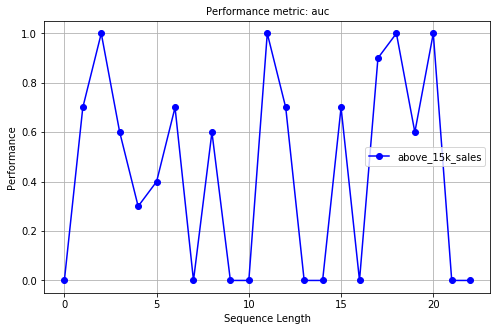

[<Figure size 576x360 with 1 Axes>]

In [33]:
from evaluation import Metrics
from evaluation import print_performance

# Evaluate predictor model
result = Metrics(metric_sets, metric_parameters).evaluate(dataset_testing.label, test_y_hat)
print('Finish predictor model evaluation.')

print('Overall performance')
print_performance(result, metric_sets, metric_parameters)

In [18]:
result

{'above_15k_sales + auc': array([0. , 0.1, 0.4, 0. , 0. , 0. , 0. , 0.4, 0.6, 1. , 1. , 0. , 0. ,
        0. , 0.8, 0.3, 0.9, 0. , 0. , 0. , 0. , 0.9, 0.8, 1. , 0.8, 0.4,
        0.5, 0. , 0.9, 1. , 1. , 0.8, 0.6, 0.4, 0. , 1. , 1. , 1. , 0.4,
        0. , nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

## Step 9: Visualize results

(2) Visualize the predictions of a certain patient by trained predictive model.

Each prediction


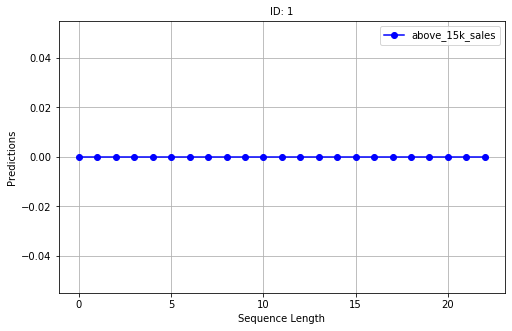

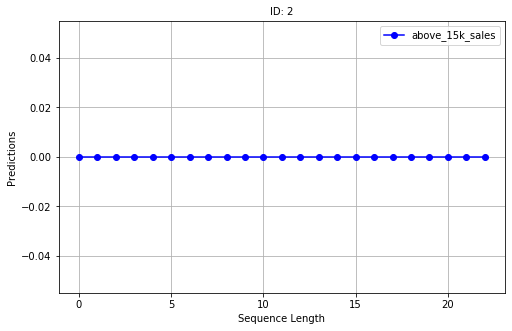

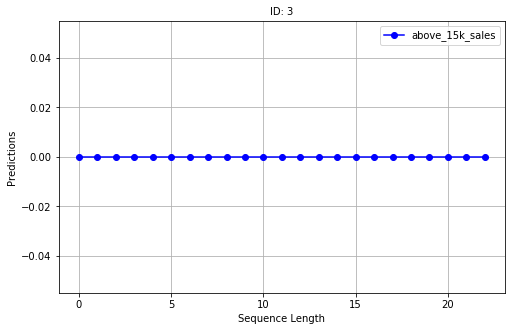

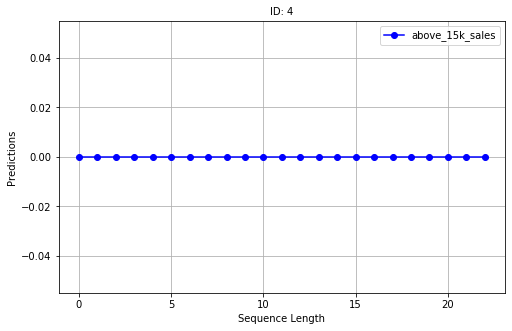

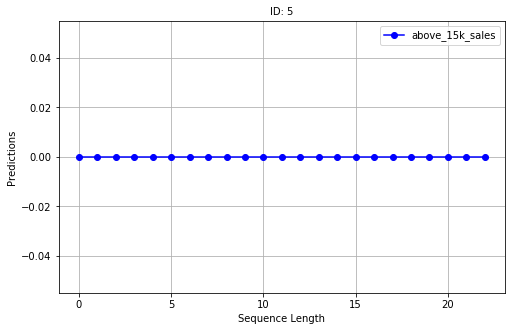

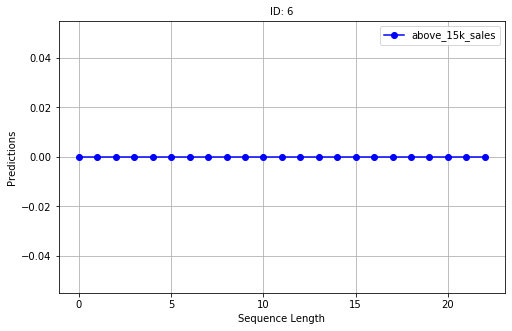

[<Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>,
 <Figure size 576x360 with 1 Axes>]

In [34]:
from evaluation import print_prediction

# Set the patient index for visualization
index = [0,1,2,3,4,5]

print('Each prediction')
print_prediction(np.rint(test_y_hat[index]), metric_parameters)

In [16]:
np.rint(test_y_hat[0])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

## Step 9: Visualize results

(3) Visualize the uncertainty of a certain patient by trained predictive and uncertainty model.

Uncertainty estimations


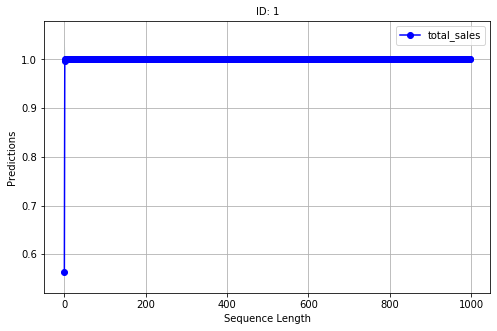

[<Figure size 576x360 with 1 Axes>]

In [22]:
from evaluation import print_uncertainty

print('Uncertainty estimations')
print_uncertainty (test_y_hat[index], test_ci_hat[index], metric_parameters)

## Step 9: Visualize results

(4) Visualize the interpretation of a certain patient prediction.

Model interpretation


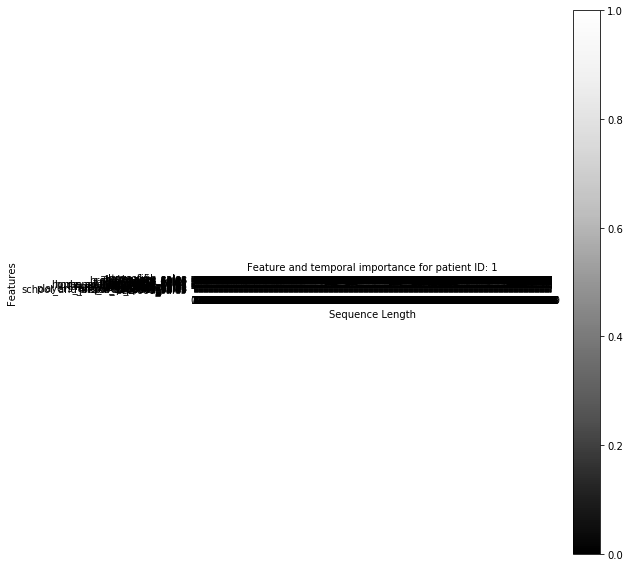

[<Figure size 576x720 with 2 Axes>]

In [23]:
from evaluation import print_interpretation

print('Model interpretation')
print_interpretation (test_s_hat[index], dataset_training.feature_name, metric_parameters, model_parameters)

In [27]:
test_s_hat.shape

(6, 1000, 34)

In [38]:
#test_s
id1 = dataset_testing.temporal_data[dataset_testing.temporal_data["id"] == 1]
id1["above_15k_sales"][100:110]

100    0.0
101    0.0
102    0.0
103    0.0
104    0.0
105    0.0
106    0.0
107    0.0
108    0.0
109    0.0
Name: above_15k_sales, dtype: float64

In [41]:
test_s_hat[0, 100:110].shape

(10, 34)

In [42]:
test_s_hat.shape

(6, 1000, 34)